<a href="https://colab.research.google.com/github/bhagarathi-beep/Alzheimer-s-Disease-Prediction-/blob/main/vgg19_alzheimer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

print("✅ TensorFlow:", tf.__version__)

✅ TensorFlow: 2.20.0


In [ ]:
BASE_DIR = os.path.join(os.getcwd(), "dataset")
CLASS_NAMES = ["AD", "MCI", "NC"]
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [ ]:
for cls in CLASS_NAMES:
    folder = pathlib.Path(BASE_DIR) / cls
    if not folder.exists():
        raise FileNotFoundError(f" Folder missing: {folder}")
print("Dataset folders found.\n")

Dataset folders found.



In [ ]:
def list_images_with_labels(base_dir, class_names):
    paths, labels = [], []
    for idx, cls in enumerate(class_names):
        folder = pathlib.Path(base_dir) / cls
        for p in folder.rglob("*"):
            if p.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                paths.append(str(p))
                labels.append(idx)
    return np.array(paths), np.array(labels)

def is_image_ok(path):
    try:
        with Image.open(path) as im:
            im.verify()
        return True
    except Exception:
        return False

all_paths, all_labels = list_images_with_labels(BASE_DIR, CLASS_NAMES)
ok_mask = np.array([is_image_ok(p) for p in all_paths])
paths, labels = all_paths[ok_mask], all_labels
print(f"{len(paths)} valid images found (removed {len(all_paths)-len(paths)} bad files)\n")


7500 valid images found (removed 0 bad files)



In [ ]:
X_train, X_tmp, y_train, y_tmp = train_test_split(paths, labels, test_size=0.30, random_state=SEED, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}\n")

Train: 5250, Val: 1125, Test: 1125



In [ ]:
def decode_and_preprocess(filename, label):
    img = tf.io.read_file(filename)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img, tf.one_hot(label, depth=len(CLASS_NAMES))

AUTOTUNE = tf.data.AUTOTUNE
augmenter = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

def make_dataset(X, y, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(len(X), seed=SEED)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (augmenter(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_dataset(X_train, y_train, shuffle=True, augment=True)
val_ds = make_dataset(X_val, y_val)
test_ds = make_dataset(X_test, y_test)

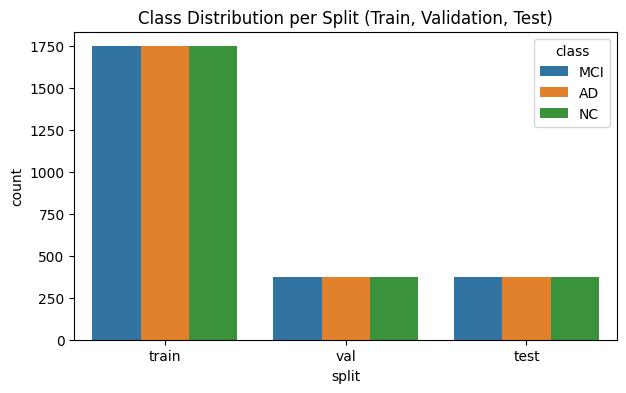

In [ ]:
df = pd.DataFrame({
    "path": np.concatenate([X_train, X_val, X_test]),
    "label": np.concatenate([y_train, y_val, y_test]),
    "split": (["train"]*len(X_train)) + (["val"]*len(X_val)) + (["test"]*len(X_test))
})
df["class"] = df["label"].map({i: c for i, c in enumerate(CLASS_NAMES)})

plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="split", hue="class")
plt.title("Class Distribution per Split (Train, Validation, Test)")
plt.show()

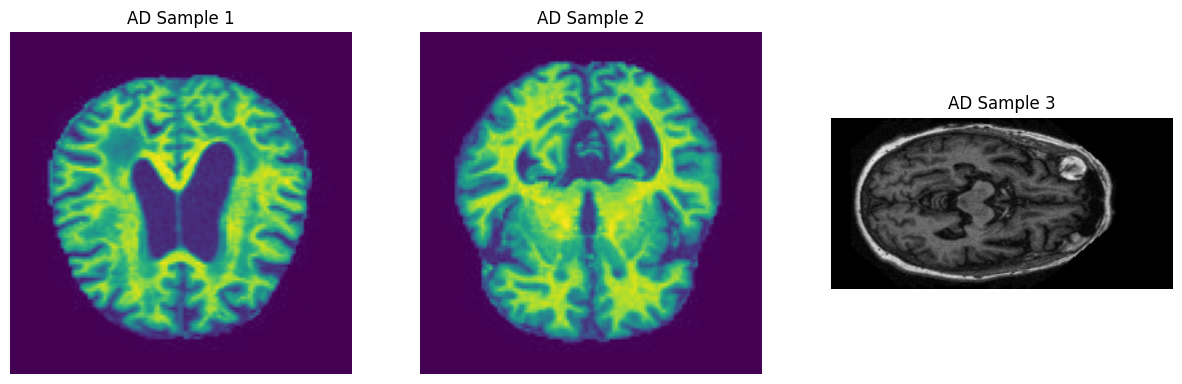

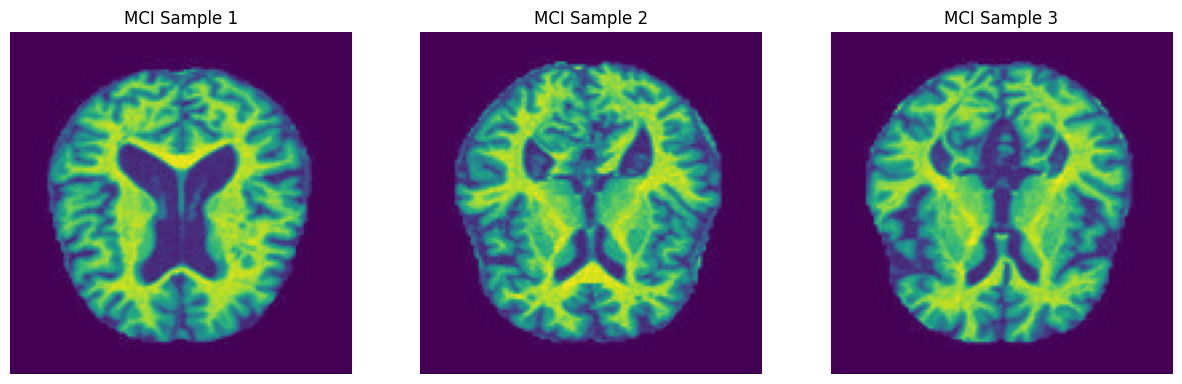

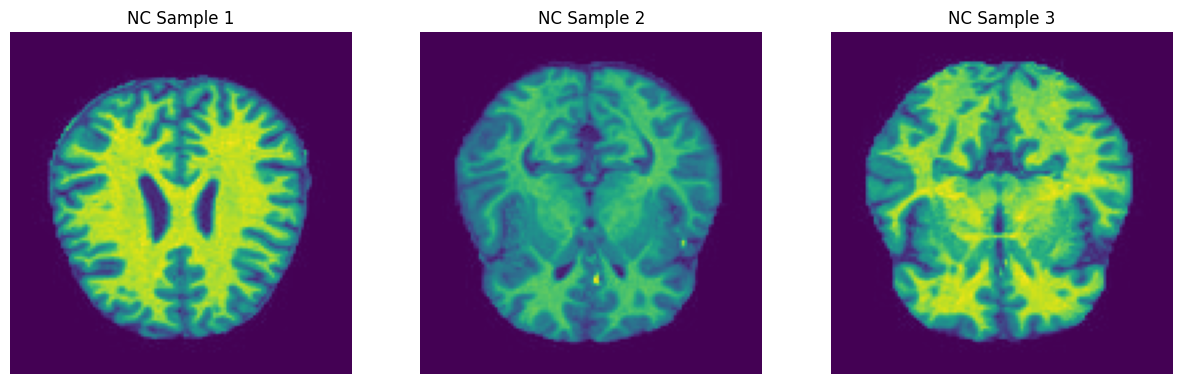

In [ ]:
def display_sample_images(class_name, sample_count=3):
    class_folder = pathlib.Path(BASE_DIR) / class_name
    sample_images = random.sample(list(class_folder.rglob("*")), sample_count)

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = Image.open(img_path)
        plt.subplot(1, sample_count, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} Sample {i+1}")
    plt.show()

for class_name in CLASS_NAMES:
    display_sample_images(class_name, sample_count=3)

In [ ]:
base_model = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
base_model.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,483 (76.89 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 770s 5s/step - accuracy: 0.5286 - loss: 1.0611 - val_accuracy: 0.6107 - val_loss: 0.8047
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step - accuracy: 0.5796 - loss: 0.8415 - val_accuracy: 0.6320 - val_loss: 0.7698
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 705s 4s/step - accuracy: 0.6130 - loss: 0.8118 - val_accuracy: 0.6596 - val_loss: 0.7440
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 7803s 48s/step - accuracy: 0.6225 - loss: 0.7928 - val_accuracy: 0.6720 - val_loss: 0.7248
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 632s 4s/step - accuracy: 0.6251 - loss: 0.7730 - val_accuracy: 0.6213 - val_loss: 0.7619
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 697s 4s/step - accuracy: 0.6263 - loss: 0.7710 - val_accuracy: 0.6027 - val_loss: 0.7974
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 828s 5s/step - accuracy: 0.6429 - loss: 0.7495 - val_accuracy: 0.7120 - val_loss: 0.6702
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 785s 5s/step - accuracy: 0.6524 - loss: 0.7274 - val_ac

In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="categorical_crossentropy", metrics=["accuracy"])
history_ft = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[early_stopping])

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 742s 4s/step - accuracy: 0.6899 - loss: 0.6712 - val_accuracy: 0.7529 - val_loss: 0.5818
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 870s 5s/step - accuracy: 0.7274 - loss: 0.6051 - val_accuracy: 0.7884 - val_loss: 0.5262
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 835s 5s/step - accuracy: 0.7724 - loss: 0.5324 - val_accuracy: 0.7920 - val_loss: 0.4834
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 929s 6s/step - accuracy: 0.7909 - loss: 0.4884 - val_accuracy: 0.8267 - val_loss: 0.4259
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 866s 5s/step - accuracy: 0.8168 - loss: 0.4450 - val_accuracy: 0.8356 - val_loss: 0.3948
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 905s 5s/step - accuracy: 0.8335 - loss: 0.4032 - val_accuracy: 0.8507 - val_loss: 0.3595
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 911s 6s/step - accuracy: 0.8516 - loss: 0.3715 - val_accuracy: 0.8516 - val_loss: 0.3754
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 876s 5s/step - accuracy: 0.8663 - loss: 0.3411 - val_accu

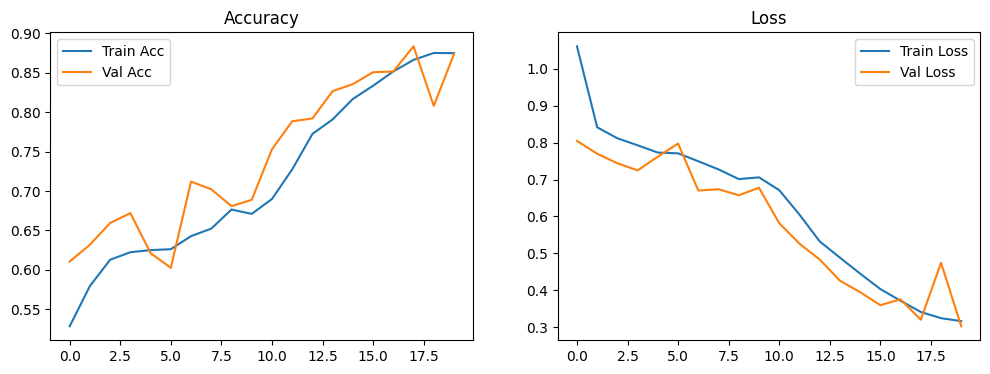

In [ ]:
def plot_history(histories):
    acc = histories[0].history["accuracy"] + histories[1].history["accuracy"]
    val_acc = histories[0].history["val_accuracy"] + histories[1].history["val_accuracy"]
    loss = histories[0].history["loss"] + histories[1].history["loss"]
    val_loss = histories[0].history["val_loss"] + histories[1].history["val_loss"]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label="Train Acc"); plt.plot(val_acc, label="Val Acc")
    plt.legend(); plt.title("Accuracy")
    plt.subplot(1, 2, 2)
    plt.plot(loss, label="Train Loss"); plt.plot(val_loss, label="Val Loss")
    plt.legend(); plt.title("Loss")
    plt.show()

plot_history([history, history_ft])


In [ ]:
train_acc = model.evaluate(train_ds, verbose=0)[1]
val_acc = model.evaluate(val_ds, verbose=0)[1]
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f" Val Accuracy:   {val_acc:.4f}")
print(f" Test Accuracy:  {test_acc:.4f}\n")


Train Accuracy: 0.9253
 Val Accuracy:   0.8738
 Test Accuracy:  0.8880



In [ ]:
y_true, y_pred = [], []
for imgs, labels in test_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Classification Report:

              precision    recall  f1-score   support

          AD       0.97      0.90      0.94       375
         MCI       0.82      0.89      0.85       375
          NC       0.88      0.87      0.87       375

    accuracy                           0.89      1125
   macro avg       0.89      0.89      0.89      1125
weighted avg       0.89      0.89      0.89      1125



2025-11-02 22:28:42.954937: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


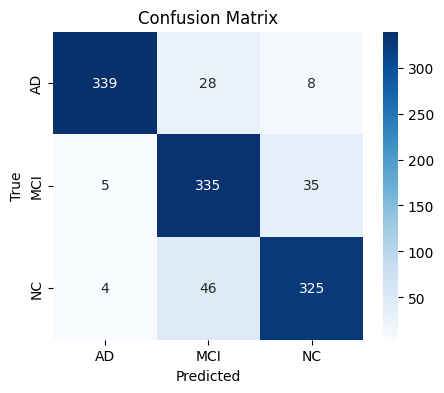

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

In [ ]:
def visualize_features(model, image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)

    # Check model layers
    for i, layer in enumerate(model.layers):
        print(f"Layer {i}: {layer.name}, Output Shape: {layer.output.shape}")

    # Choose a convolutional layer, e.g., model.layers[2] (change this index as per your findings)
    feature_model = keras.Model(inputs=model.input, outputs=model.layers[2].output)
    feature_map = feature_model.predict(img)

    print("Feature map shape:", feature_map.shape)

    if len(feature_map.shape) == 4:
        num_features = feature_map.shape[-1]
        size = feature_map.shape[1]

        feature_map = feature_map[0]
        display_grid = np.zeros((size, size * num_features))

        for i in range(num_features):
            x = feature_map[:, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size: (i + 1) * size] = x

        scale = 20. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title("Feature Maps")
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()
    else:
        print("Unexpected feature map shape. Please check the model layer output.")

sample_image_path = X_test[0]
visualize_features(model, sample_image_path)


Layer 0: input_layer_2, Output Shape: (None, 224, 224, 3)
Layer 1: vgg19, Output Shape: (None, 7, 7, 512)
Layer 2: global_average_pooling2d, Output Shape: (None, 512)
Layer 3: dense, Output Shape: (None, 256)
Layer 4: dropout, Output Shape: (None, 256)
Layer 5: dense_1, Output Shape: (None, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Feature map shape: (1, 512)
Unexpected feature map shape. Please check the model layer output.


In [ ]:
save_path = os.path.join(os.getcwd(), "vgg19_alzheimer_model.keras")
model.save(save_path)
print(f" Model saved successfully at: {save_path}")

print("\n Training complete!")

 Model saved successfully at: /Users/pappu/Downloads/FYP/Prabha/vgg19_alzheimer_model.keras

 Training complete!
